## Running inference on UKBB data

This file is part of the Glaucoma Phenotype ML Estimation project.

 Glaucoma Phenotype ML Estimation is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.


The Glaucoma Phenotype ML Estimation project is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with the Glaucoma Phenotype ML Estimation project.  If not, see <http://www.gnu.org/licenses/>.


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [6]:
import pickle as pkl
import os
from pathlib import Path
from multiprocessing import Pool, cpu_count
import numpy as np
import pandas as pd
import zipfile
#import imageio
import matplotlib.pyplot as plt
import seaborn as sns
from fastai.vision import *
from PIL import Image
from IPython.display import display
from glaucoma.helpers.glaucoma_helpers import *


In [5]:
from fastai.distributed import *

In [6]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [7]:
##### PLEASE SET AS REQUIRED########
WORKING_DIR = Path(os.getcwd())
DATA_DIR = WORKING_DIR / 'data'
META_DIR = DATA_DIR / 'metadata'
TRAIN_DIR = DATA_DIR / 'train'
UKBB_DIR = DATA_DIR 'retinal_images/UKBB'
CROP_DIR = DATA_DIR /'retinal_images/cropped_UKBB')
C_CLSA_DIR = DATA_DIR / 'retinal_images/cropped_CLSA')
GRADE_DIR = DATA_DIR / "gradable"
CLSA_DIR =DATA_DIR / 'retinal_images/CLSA')

In [8]:
# make these folders if required
#os.mkdir(CROP_DIR / 'crop_image_21015_0_0_png' )
#os.mkdir(CROP_DIR / 'crop_image_21015_0_1_png' )
#os.mkdir(CROP_DIR / 'crop_image_21015_1_0_png' )
#os.mkdir(CROP_DIR / 'crop_image_21016_0_0_png' )
#os.mkdir(CROP_DIR / 'crop_image_21016_0_1_png' )
#os.mkdir(CROP_DIR / 'crop_image_21016_1_0_png' )

In [37]:
ukbb_image_folders_left =[
 'raw_image_21015_0_0_png',
 'raw_image_21015_0_1_png',
 'raw_image_21015_1_0_png',
]

ukbb_image_folders_right =[
'raw_image_21016_1_0_png',
 'raw_image_21016_0_0_png',
 'raw_image_21016_0_1_png']

## Cropping images

In [148]:
ukbb_images_left = {dir_name:parse_files(UKBB_DIR / dir_name) for dir_name in ukbb_image_folders_left}
ukbb_images_right = {dir_name:parse_files(UKBB_DIR / dir_name) for dir_name in ukbb_image_folders_right}

#ukbb_images_left_list = [item for sublist in ukbb_images_left for item in sublist]
#ukbb_images_right_list = [item for sublist in ukbb_images_right for item in sublist]

In [76]:
print("left :" + str(len(ukbb_images_left_list)) + " right: " + str(len(ukbb_images_right_list)))

left :69 right: 69


In [262]:
im = Image.open(ukbb_images_left[ukbb_image_folders_left[0]][1])
width, height = im.size 

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#img=mpimg.imread(ukbb_images_right[0])
imgplot = plt.imshow(im)
plt.show()

In [163]:
left = 200
top = 350
right = 1040 + left
bottom = 800 +top
iml = im.crop((left,top,right,bottom))

In [ ]:
plt.imshow(iml)

In [ ]:
left = 200
top = 350
right = 1040 + left
bottom = 800 +top
save_path = CROP_DIR / 'crop_image_21015_0_0_png'
crop_files(ukbb_images_left[ukbb_image_folders_left[0]],(left,top,right,bottom),save_path)

In [153]:
list_files = parse_files(CROP_DIR / 'crop_image_21016_0_0_png')

## Running inference

### Gradabillity

In [7]:
path_img = GRADE_DIR

In [8]:
#Load the gradabillity models
src = ImageList.from_folder(str(path_img)).split_by_rand_pct(seed=42).label_from_folder()
tfms = get_transforms( max_lighting = 0.25) # or tfms=None if none are needed
size=(800,1040) # size=(224,224) or (400,224)
data = src.transform(tfms=tfms, size=size, resize_method=ResizeMethod.SQUISH).databunch(num_workers=4).normalize(imagenet_stats)


In [ ]:
#using smaller image size
src = ImageList.from_folder(str(path_img)).split_by_rand_pct(seed=42).label_from_folder()
tfms = get_transforms(max_lighting = 0.25) # or tfms=None if none are needed
size=(800,1040) # size=(224,224) or (400,224)
data = src.transform(tfms=tfms, size=size, resize_method=ResizeMethod.SQUISH).databunch(num_workers=4).normalize(imagenet_stats)

In [ ]:
data.show_batch(3, figsize=(10,10), hide_axis=False)


In [121]:
learn_grade = cnn_learner(data,models.resnet34, pretrained = True)

In [ ]:
learn_grade.load('gradable_res34_removed_best_heat_2')

In [61]:
#load actual full UKBB data
crop_paths = [CROP_DIR /'crop_image_21015_0_0_png',
         CROP_DIR /'crop_image_21015_0_1_png',
         CROP_DIR /'crop_image_21015_1_0_png',
         CROP_DIR /'crop_image_21016_0_0_png',
         CROP_DIR /'crop_image_21016_0_1_png',
         CROP_DIR /'crop_image_21016_1_0_png'
        ]

In [81]:
crop_names = [os.path.basename(pth) for pth in crop_paths]

In [62]:
test_sets = [ImageList.from_folder(path) for path in crop_paths]

In [66]:
preds = {}
for i,test in enumerate(test_sets):
    learn_grade.data.add_test(test)
    pred = learn_grade.get_preds(DatasetType.Test)
    preds[os.path.basename(crop_paths[i])] = pred

### Testing prediction

In [123]:
p,y,losses = learn_grade.get_preds(with_loss=True)

In [125]:
interp = ClassificationInterpretation(learn_grade,p,y,losses)

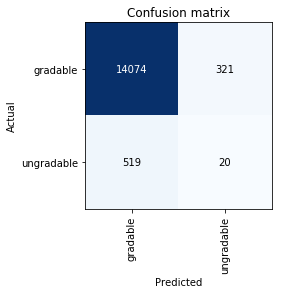

In [126]:
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(9,figsize = (12,12))


In [128]:
accuracy(p,y)

tensor(0.9438)

In [85]:
learn_grade.data.test_ds.tfms

[RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={'padding_mode': 'reflection', 'row_pct': 0.5, 'col_pct': 0.5}, do_run=True, is_random=True, use_on_y=True)]

In [67]:
save_path = WORKING_DIR /"UKBB_gradabillity_predictions_v2.pkl"
pkl.dump(preds,open(save_path,'wb'))
#preds = pkl.load(open(save_path, 'rb'))

In [70]:
grade_preds = pkl.load(open(save_path, 'rb'))

In [175]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

### VCDR inference

In [9]:
path_img = TRAIN_DIR

In [10]:
src = ImageList.from_folder(str(path_img)).split_by_rand_pct(seed=42).label_from_folder()
tfms = get_transforms( max_lighting = 0.25) # or tfms=None if none are needed
size=(800,1040) # size=(224,224) or (400,224)
data = src.transform(tfms=tfms, size=size, resize_method=ResizeMethod.SQUISH).databunch(num_workers=4).normalize(imagenet_stats)


In [74]:
learn_vcdr = cnn_learner(data,models.resnet34, pretrained = True)

In [ ]:
learn_vcdr.load('g_model_e9_stage_2')

In [76]:
vc_preds = {}
for i,test in enumerate(test_sets):
    learn_vcdr.data.add_test(test)
    pred = learn_vcdr.get_preds(DatasetType.Test)
    vc_preds[os.path.basename(crop_paths[i])] = pred

In [77]:
save_path = WORKING_DIR /"UKBB_vcdr_predictions_v2.pkl"
pkl.dump(vc_preds,open(save_path,'wb'))
#vc_preds = pkl.load(open(save_path,'rb'))

## Building DataFrame

In [248]:
combined_test_set = {}
for i,ts in enumerate(test_sets):
    ts_list = list(ts.items)
    ts_list = [os.path.basename(x) for x in ts_list]
    combined_test_set[crop_names[i]] = ts_list
    

In [241]:
def build_df_result(file_names, preds, preds2):
    
    file_names = np.asarray(file_names)
    file_names = file_names.reshape(len(file_names),1)
    pred_arr = preds.numpy()
    preds2_arr = preds2.numpy()
    print(file_names.shape)
    print(preds.shape)
    print(preds2.shape)
    full_arr = np.concatenate((file_names,pred_arr,preds2_arr),axis=1)
    df = pd.DataFrame(full_arr)
    df.set_index(0,inplace = True)
    df = df.rename(columns = {0:'file',1:'gradable',2:'ungradable',3:'vcdr_estimate'})
    df.index.rename("file_name",inplace =True)
    return df
    
    
    

In [ ]:
np.concatenate(((tt,preds[list(preds.keys())[0]][0].numpy())),axis =1)

In [249]:
keys = list(combined_test_set.keys())
df_dict = {}
for key in keys:
    print(key)
    df = build_df_result(combined_test_set[key], preds[key][0],vc_preds[key][0])
    df_dict[key] = df

crop_image_21015_0_0_png
(67708, 1)
torch.Size([67708, 2])
torch.Size([67708, 1])
crop_image_21015_0_1_png
(522, 1)
torch.Size([522, 2])
torch.Size([522, 1])
crop_image_21015_1_0_png
(19320, 1)
torch.Size([19320, 2])
torch.Size([19320, 1])
crop_image_21016_0_0_png
(68138, 1)
torch.Size([68138, 2])
torch.Size([68138, 1])
crop_image_21016_0_1_png
(686, 1)
torch.Size([686, 2])
torch.Size([686, 1])
crop_image_21016_1_0_png
(19396, 1)
torch.Size([19396, 2])
torch.Size([19396, 1])


In [257]:
df_full = pd.concat([i for i in df_dict.values()])

In [268]:
pkl.dump(df_dict,open(WORKING_DIR / "UKBB_inference_python_dictionaries.pkl",'wb'))